In [70]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)

In [71]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

In [72]:
library(data.table)
library(hts)  

In [73]:
df_eu  <-  read.csv(file="hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006      
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [74]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [75]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(11,0,0)
var_sarpdq   <-  c(2,0,0)
var_char  <-  c(4,2)

In [76]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
# gts_train  <- window(y, start=19, end=46)
# gts_test  <- window(y, start=47, end=54)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [77]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal = var_sarpdq,  include.mean = TRUE, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq,  seasonal = var_sarpdq, include.mean = TRUE, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 82 328 
Total number of series: 411 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20320.1698  -5030.9537  -1399.7740  -2817.0262  -1875.7827   4521.8421
 [7]  12482.8384  19305.0856   9214.0828   7871.4188   6576.1790   1668.1495
[13] -10580.8902   1270.2769   2430.4867  -1809.5061   -448.2662   5316.9359
[19]  13995.2189  21285.0421  12902.1219  11671.9621   8652.9478   2078.9394
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 82 328 
Total number of series: 411 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100

In [78]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [79]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [80]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [81]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -18861.381 -18357.981 -13116.838  -6711.682  -3362.146  15145.351
 [7]  17046.199   2395.796  -1880.303  -9893.146 -15269.115 -41027.580
[13] -22513.818 -19828.565 -15664.063 -15851.436  -9136.776   4327.751
[19]   3175.891  -9825.622 -13927.834 -22332.943 -30749.379 -53700.735

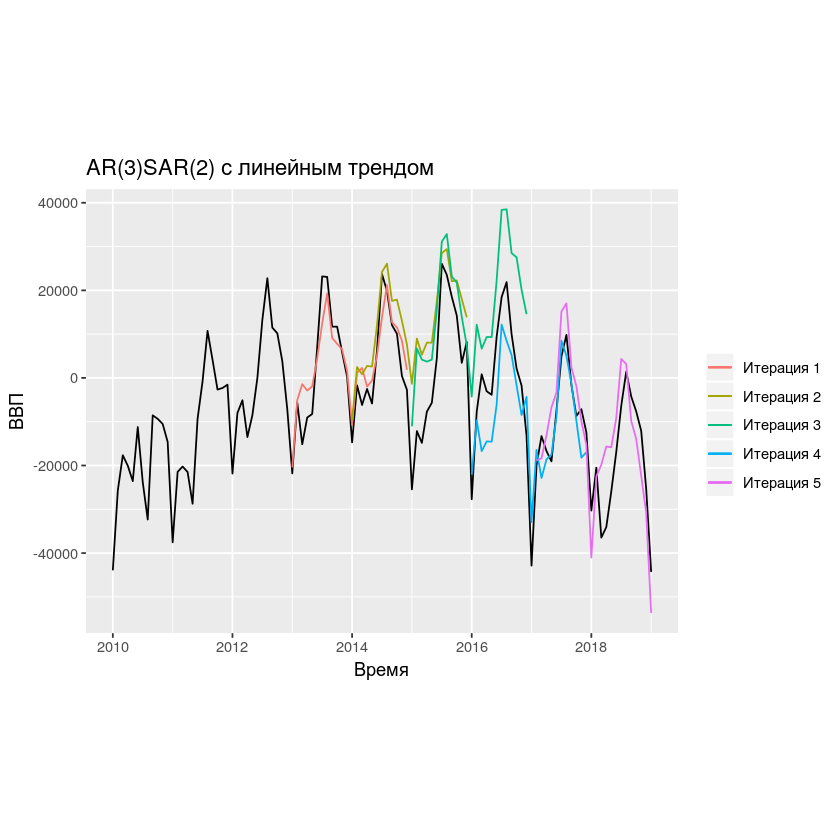

In [82]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [83]:
df_acc[-3,]

,ME,RMSE,MAPE,Iteration
1,-1469.298,5591.527,148.12424,1
2,-9412.100,11199.370,249.03913,13
4,3702.971,8090.806,174.56569,37
5,-2252.527,8513.035,71.08132,50


In [84]:
colMeans(df_acc[-3,])

ME       RMSE       MAPE  Iteration 
-2357.7387  8348.6844   160.7026    25.2500

In [85]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-4670.5678  9793.1239   180.3282    25.2000

In [86]:
df_mean_acc <- readRDS("df_mean_acc.rds")
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9616.41574753439
2 level (state),62.0365866565657,242.432733556294,11173.0672424215
2 level (type),61.8934203477981,241.696134642821,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


In [87]:
df_mean_acc[2,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9793.12390204049
2 level (state),62.0365866565657,242.432733556294,11173.0672424215
2 level (type),61.8934203477981,241.696134642821,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


In [88]:
df_acc

ME,RMSE,MAPE,Iteration
-1469.298,5591.527,148.12424,1
-9412.100,11199.370,249.03913,13
-13921.884,15570.882,258.83057,25
3702.971,8090.806,174.56569,37
-2252.527,8513.035,71.08132,50


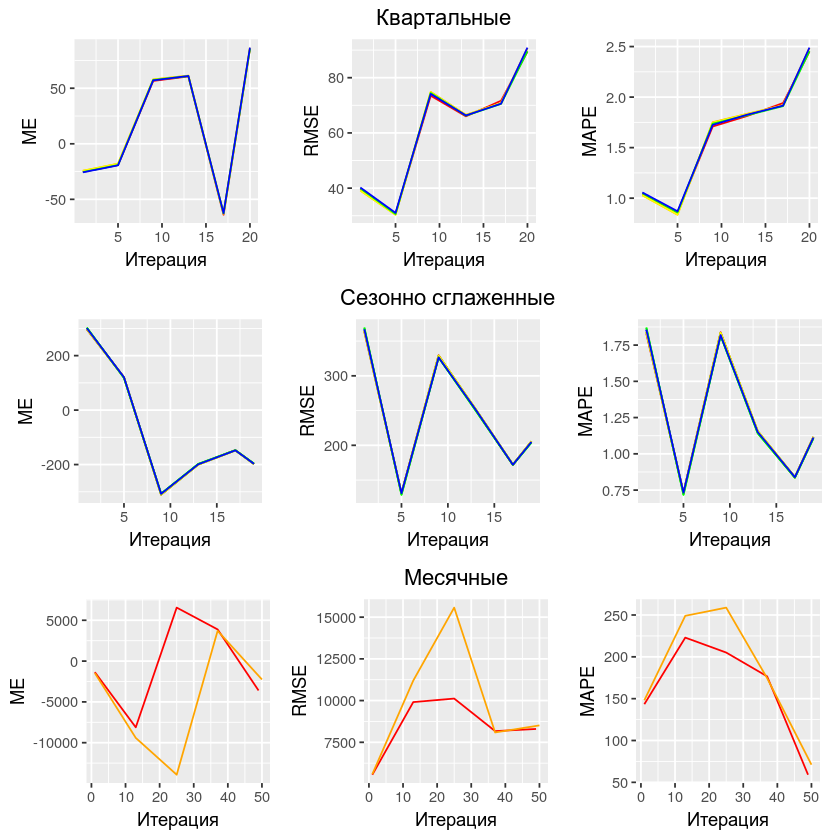

In [89]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [90]:
df_eu  <-  read.csv(file="hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [91]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [92]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [93]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal.periods = var_freq, include.mean = TRUE, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal.periods = var_freq, include.mean = TRUE, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 82 
Total number of series: 83 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -23085.714  -4445.478   2082.335  -1549.534  -1444.498  10691.888
 [7]  11994.984  13846.945  19029.412  17250.746  14206.042   8016.505
[13] -11593.424   5202.237   8827.468   5612.296   3119.642  17954.750
[19]  24185.528  31429.580  29030.231  25073.594  23083.165  19338.481
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 82 
Total number of series: 83 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 82 
Total number of series: 83 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -14797.987   1527.338  -1810.030  -1132.299  -2257.322  13006.231
 [7]  25951.939  31740.061  22088.012  19486.641  15661.557  11203.636
[13]  -5532.903   9871.991   7448.528   6086.594   7453.359  20355.073
[19]  34022.927  39894.109  29377.437  27744.867  22641.344  15737.499
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 82 
Total number of series: 83 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -25453 -12145 -14835  -7712  -5673   4497  26076  23541
[21]  18543  14250   3448   8186
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 82 
Total number of series: 83 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -11064.312   6641.527   4124.894   3671.944   4115.582  15372.179
 [7]  30980.831  32699.456  23079.213  21671.585  13878.251   7457.176
[13]  -4291.480  12065.987   6635.760   9272.661   9250.830  22091.601
[19]  38167.152  38319.530  28370.318  27395.805  20048.030  14471.916
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 82 
Total number of series: 83 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -25453 -12145 -14835  -7712  -5673   4497  26076  23541  18543  14250
[11]   3448   8186 -27719  -7767    834  -3050  -3848   9358  18466  21879
[21]   9990   2149  -1754 -13195
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 82 
Total number of series: 83 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -11372.242   3754.865   1212.786   3531.866   2883.370  14972.102
 [7]  28766.666  29431.677  24691.794  21518.805  14048.379  12088.186
[13]  -7152.917   8145.304   5711.197   8102.680   7490.284  19590.102
[19]  33402.122  34075.266  29343.586  26170.132  18701.776  16756.401
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 82 
Total number of series: 83 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -27719  -7767    834  -3050  -3848   9358  18466  21879   9990   2149
[11]  -1754 -13195 -42866 -19974 -13281 -16692 -19053  -7468   4916   9856
[21]  -1614  -8689  -7140 -12451
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 82 
Total number of series: 83 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20745.636 -16038.148 -15936.429 -15506.483  -3570.250  10351.639
 [7]  11455.837   2250.761  -4216.815 -10750.248 -15961.289 -47941.146
[13] -26728.471 -20540.071 -21959.537 -22003.512  -9605.592   2458.994
[19]   4444.028  -5766.948 -12742.366 -18269.275 -25839.093 -56882.465
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 82 
Total number of series: 83 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19974 -13281 -16692 -19053  -7468   4916   9856  -1614  -8689  -7140
[11] -12451 -30308 -20506 -36471 -34071 -25938 -16893  -6336   1411  -4243
[21]  -7651 -12081 -25307 -44311


In [94]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [95]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [96]:
df_acc

ME,RMSE,MAPE,Iteration
-7756.6326,11275.844,471.44726,1
-11010.8584,12743.384,283.12248,13
-14015.0182,15668.330,260.66666,25
-19790.7162,22111.852,320.54302,37
-593.8534,7243.007,56.68427,50


In [97]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -20799.842 -16085.734 -15989.651 -15554.246  -3595.369  10354.725
 [7]  11454.772   2230.662  -4252.912 -10805.962 -16024.682 -48092.809
[13] -26840.778 -20630.834 -22066.260 -22105.263  -9666.644   2420.561
[19]   4410.463  -5838.914 -12844.746 -18378.222 -25990.880 -57136.744

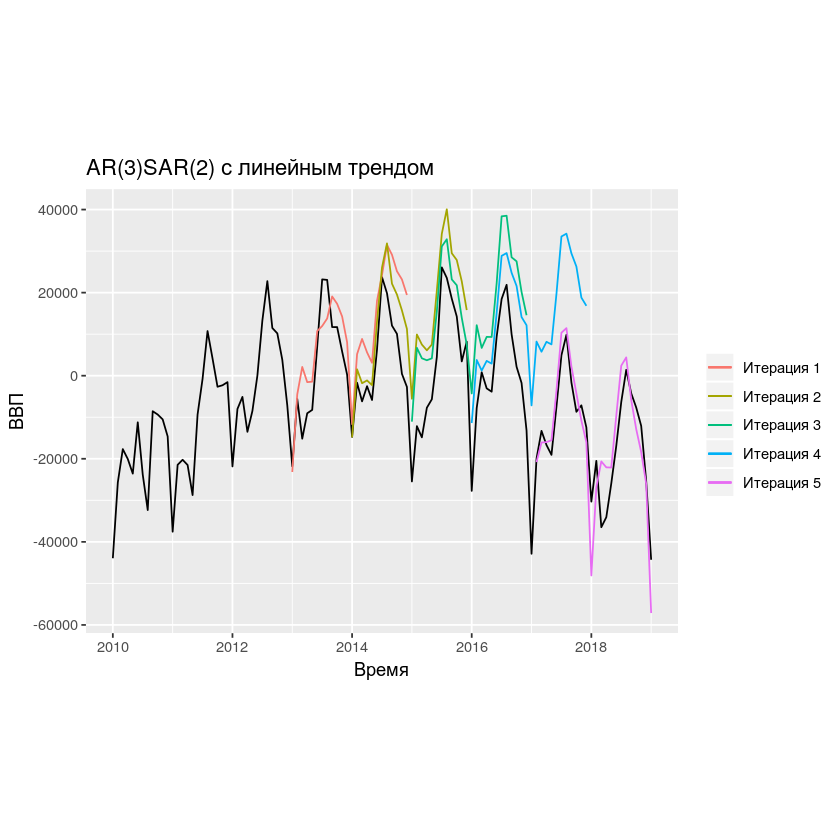

In [98]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [99]:
colMeans(df_acc)

ME        RMSE        MAPE   Iteration 
-10633.4158  13808.4836    278.4927     25.2000

In [100]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [101]:
df_mean_acc[3,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9793.12390204049
2 level (state),62.0365866565657,242.432733556294,13808.4835883885
2 level (type),61.8934203477981,241.696134642821,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


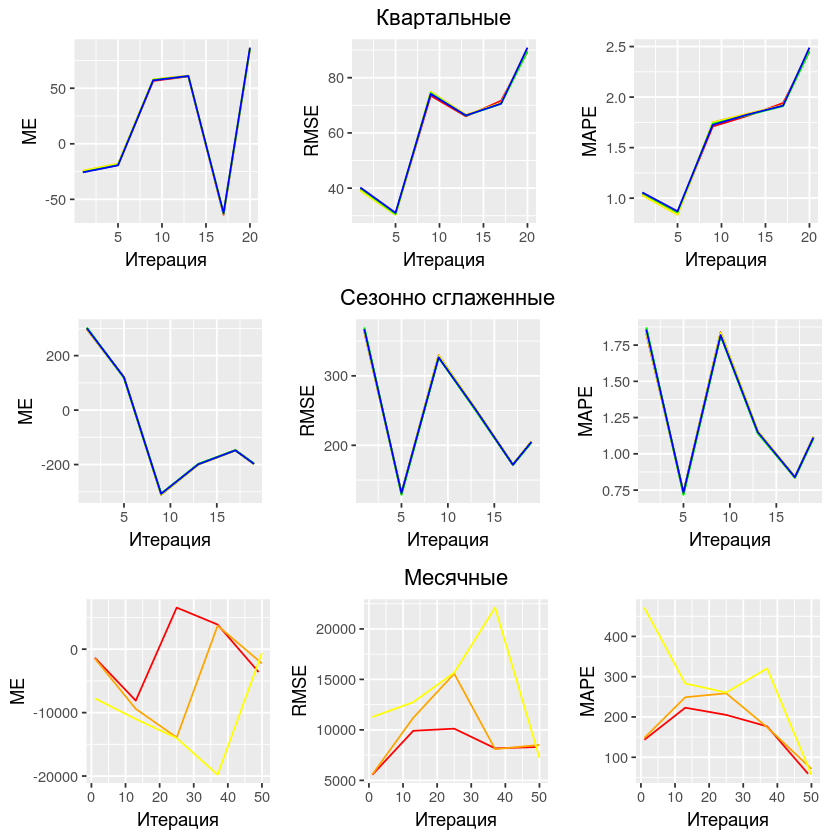

In [102]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [103]:
df_eu  <-  read.csv(file="hts_rus_summed_type.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [104]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [105]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [106]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal.periods = var_freq, include.mean = TRUE, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal.periods = var_freq, include.mean = TRUE, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

    
    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -19291.9676  -1761.2171   2617.8364   -600.8495   1126.3752  10785.3256
 [7]  13791.6512  15255.8577  17916.2861  18470.6043  13841.0143   7368.6470
[13]  -7231.2259   7756.8230  10115.6730   7719.2917   6059.8374  18319.1384
[19]  23999.9564  29974.6893  27870.8045  25084.3932  22980.5425  19304.5762
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -13221.1258    904.6978  -3024.6386   -907.8399  -1611.3033  11743.8375
 [7]  27046.2793  30721.6547  20203.8826  20515.6526  14272.1661  10391.5927
[13]  -3087.2684   8419.9871   5833.5683   6483.2638   7447.9441  18164.8599
[19]  34914.0000  37859.4035  26711.8561  29002.7965  20419.0029  15326.7552
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -25453 -12145 -14835  -7712  -5673   4497  26076  23541
[21]  18543  14250   3448   8186
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -10273.471   5060.205   2628.268   3406.673   3145.591  13252.696
 [7]  30496.514  29880.213  21397.840  20578.909  10678.985   6892.180
[13]  -3722.598   9681.452   5189.901   8694.433   8071.952  18729.021
[19]  37041.339  34468.545  26177.153  26104.646  15580.034  13619.862
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -25453 -12145 -14835  -7712  -5673   4497  26076  23541  18543  14250
[11]   3448   8186 -27719  -7767    834  -3050  -3848   9358  18466  21879
[21]   9990   2149  -1754 -13195
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -12449.0024   1135.6494    482.4147   2125.2208    705.2792  14265.2449
 [7]  28090.3417  27691.8767  23467.9034  19812.8111  11867.9432  11582.6273
[13]  -8728.2956   4748.8022   4046.9009   6153.7526   5030.2459  17849.5591
[19]  32369.8529  31627.8966  27605.3121  24253.4333  15663.4446  16045.2185
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -27719  -7767    834  -3050  -3848   9358  18466  21879   9990   2149
[11]  -1754 -13195 -42866 -19974 -13281 -16692 -19053  -7468   4916   9856
[21]  -1614  -8689  -7140 -12451
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -19533.9584 -16848.2027 -15815.3376 -14617.0111  -5661.3773  10745.6295
 [7]  10621.3097    486.1241  -3352.5294 -11684.7154 -16679.0036 -46284.5133
[13] -26506.6615 -21272.6265 -21720.9122 -21854.1544 -11485.4717   2802.9570
[19]   3225.5931  -7234.5641 -11799.9078 -19435.1822 -25314.5624 -53891.5832
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19974 -13281 -16692 -19053  -7468   4916   9856  -1614  -8689  -7140
[11] -12451 -30308 -20506 -36471 -34071 -25938 -16893  -6336   1411  -4243
[21]  -7651 -12081 -25307 -44311


In [107]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [108]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [109]:
df_acc

ME,RMSE,MAPE,Iteration
-8740.6693,11602.313,476.96785,1
-10542.6260,12168.430,260.74883,13
-12446.4310,14284.863,224.89223,25
-18106.5597,20536.775,291.89726,37
-466.0141,6837.876,49.37645,50


In [110]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -20799.842 -16085.734 -15989.651 -15554.246  -3595.369  10354.725
 [7]  11454.772   2230.662  -4252.912 -10805.962 -16024.682 -48092.809
[13] -26840.778 -20630.834 -22066.260 -22105.263  -9666.644   2420.561
[19]   4410.463  -5838.914 -12844.746 -18378.222 -25990.880 -57136.744

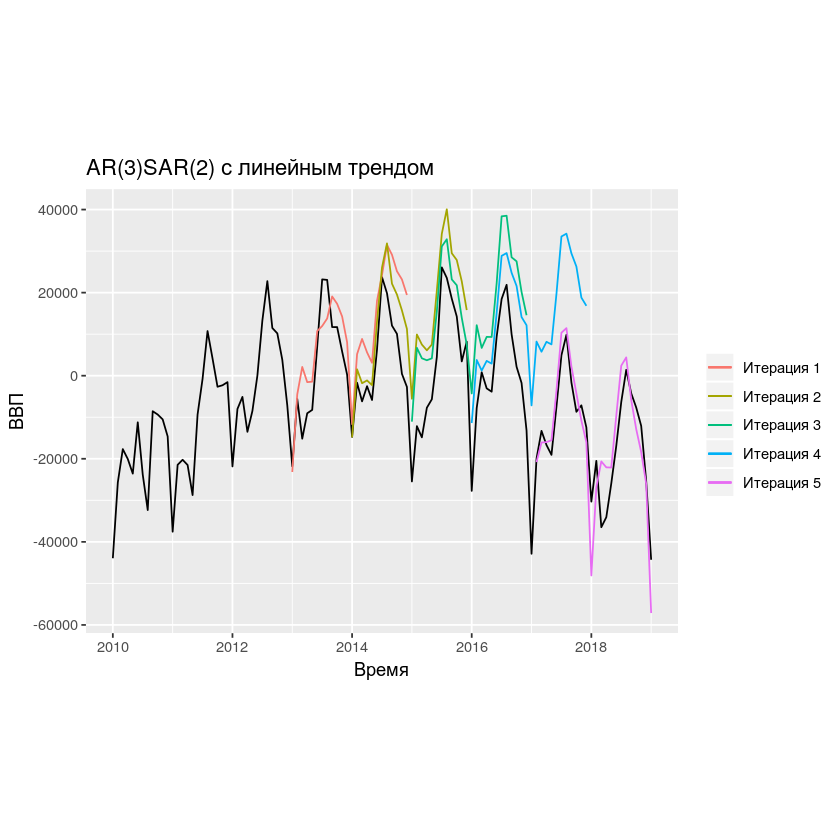

In [111]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [112]:
colMeans(df_acc)

ME        RMSE        MAPE   Iteration 
-10060.4600  13086.0514    260.7765     25.2000

In [113]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [114]:
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9793.12390204049
2 level (state),62.0365866565657,242.432733556294,13808.4835883885
2 level (type),61.8934203477981,241.696134642821,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


In [115]:
df_mean_acc[4,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9793.12390204049
2 level (state),62.0365866565657,242.432733556294,13808.4835883885
2 level (type),61.8934203477981,241.696134642821,13086.0514442162
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


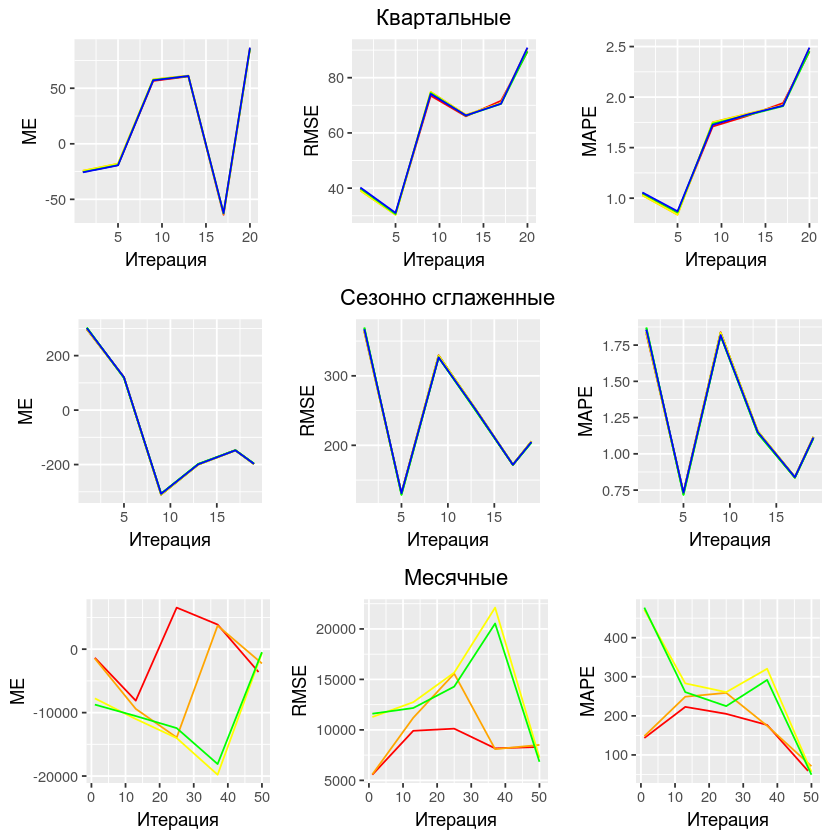

In [116]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [117]:
df_eu  <-  read.csv(file="hts_rus_summed_clust.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [118]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [119]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [120]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal.periods = var_freq, include.mean = TRUE, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal.periods = var_freq, include.mean = TRUE, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

    
    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 14 
Total number of series: 15 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21984.910  -4065.501   2098.629  -1610.942  -1004.513  10546.000
 [7]  12514.957  14381.058  18581.764  17533.202  13894.471   7650.860
[13] -10621.325   5350.420   8949.595   5609.474   3596.153  17729.690
[19]  24019.673  30976.390  28325.971  24946.295  22666.939  18850.284
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 14 
Total number of series: 15 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 14 
Total number of series: 15 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -14238.873   1093.077  -1937.894  -1281.837  -2193.673  12700.589
 [7]  25900.685  31247.933  21413.601  19518.978  15221.061  10901.104
[13]  -4905.488   9209.275   7089.289   5919.980   7305.686  19629.090
[19]  33681.142  38922.367  28314.342  27652.970  21906.061  15453.994
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 14 
Total number of series: 15 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -25453 -12145 -14835  -7712  -5673   4497  26076  23541
[21]  18543  14250   3448   8186
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 14 
Total number of series: 15 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -10797.323   6145.220   3684.220   3617.733   3850.147  14712.883
 [7]  30914.270  31843.735  22607.056  21379.835  12838.352   7335.103
[13]  -4099.718  11313.901   6207.604   9119.010   8933.858  21049.931
[19]  37913.457  37149.023  27741.117  27054.449  18610.800  14278.988
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 14 
Total number of series: 15 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -25453 -12145 -14835  -7712  -5673   4497  26076  23541  18543  14250
[11]   3448   8186 -27719  -7767    834  -3050  -3848   9358  18466  21879
[21]   9990   2149  -1754 -13195
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 14 
Total number of series: 15 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -11537.101   2990.166   1077.511   3154.045   2436.397  14601.949
 [7]  28663.375  29025.055  24176.992  21214.131  13448.711  11836.273
[13]  -7406.206   7215.145   5252.265   7597.333   6986.920  18951.018
[19]  33219.713  33484.198  28706.929  25846.057  17881.911  16496.423
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 14 
Total number of series: 15 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -27719  -7767    834  -3050  -3848   9358  18466  21879   9990   2149
[11]  -1754 -13195 -42866 -19974 -13281 -16692 -19053  -7468   4916   9856
[21]  -1614  -8689  -7140 -12451
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 14 
Total number of series: 15 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20343.092 -15809.191 -15716.828 -14984.977  -3685.199  10475.572
 [7]  11434.043   2043.464  -3925.810 -10668.225 -15888.124 -47188.896
[13] -26257.450 -20152.361 -21533.391 -21407.696  -9554.862   2671.081
[19]   4441.757  -5767.048 -12235.887 -18017.808 -25200.451 -55395.381
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 14 
Total number of series: 15 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19974 -13281 -16692 -19053  -7468   4916   9856  -1614  -8689  -7140
[11] -12451 -30308 -20506 -36471 -34071 -25938 -16893  -6336   1411  -4243
[21]  -7651 -12081 -25307 -44311


In [121]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [122]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [123]:
df_acc

ME,RMSE,MAPE,Iteration
-7801.5264,11104.914,461.14116,1
-10708.9776,12419.374,274.07564,13
-13555.7354,15247.394,249.82303,25
-19351.3421,21700.820,312.13262,37
-901.1766,7129.009,55.82699,50


In [124]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -20799.842 -16085.734 -15989.651 -15554.246  -3595.369  10354.725
 [7]  11454.772   2230.662  -4252.912 -10805.962 -16024.682 -48092.809
[13] -26840.778 -20630.834 -22066.260 -22105.263  -9666.644   2420.561
[19]   4410.463  -5838.914 -12844.746 -18378.222 -25990.880 -57136.744

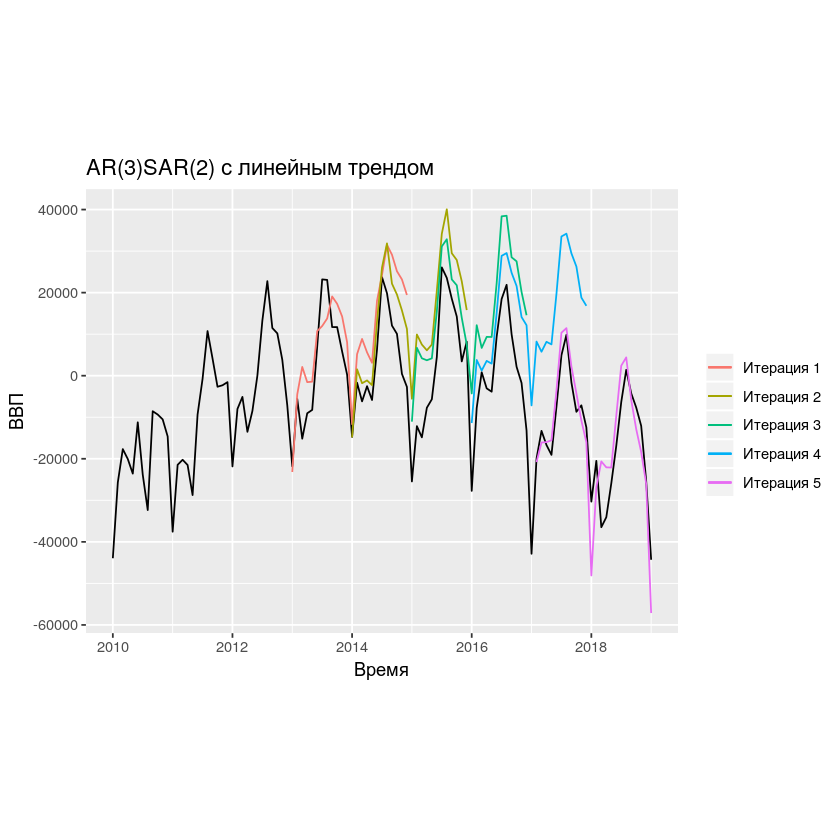

In [125]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [126]:
colMeans(df_acc)

ME        RMSE        MAPE   Iteration 
-10463.7516  13520.3023    270.5999     25.2000

In [127]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [128]:
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9793.12390204049
2 level (state),62.0365866565657,242.432733556294,13808.4835883885
2 level (type),61.8934203477981,241.696134642821,13086.0514442162
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


In [129]:
df_mean_acc[5,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.431871682589,9793.12390204049
2 level (state),62.0365866565657,242.432733556294,13808.4835883885
2 level (type),61.8934203477981,241.696134642821,13086.0514442162
2 level (clusetered),62.2035745560281,242.160670839515,13520.3023176664
3 Weighted,61.8395575588501,242.045240972104,8923.37954762796


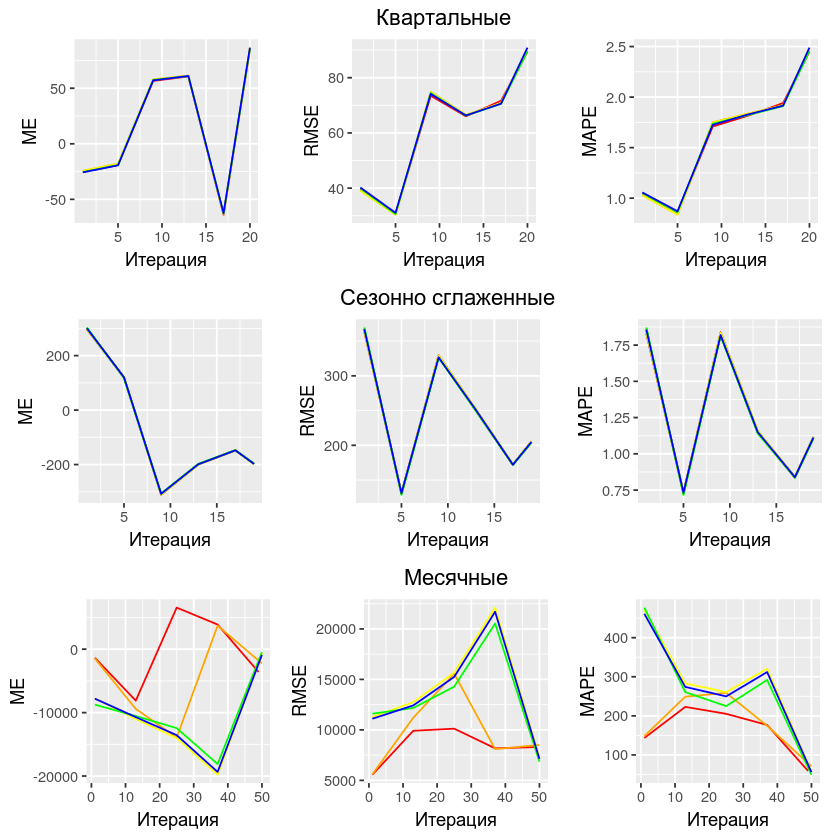

In [130]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [131]:
saveRDS(df_mean_acc, "df_mean_acc.rds")
saveRDS(plots_test_all, "plots_test_not_all.rds")